# Homework 5

Dylan Green (22420153)

Complete code can be found at https://github.com/lone-duck/hw-cs532/tree/main/hw5.

In [1]:
from evaluator import evaluate_outer
import json
import numpy as np
import sys
import matplotlib.pyplot as plt
import torch

sys.setrecursionlimit(100000)

## Program 0 (Code)

In [ ]:
## evaluator code
def evaluate_outer(e, env=None): #TODO: add sigma, or something
    
    # create env if it doesn't exist
    if env is None:
        env = standard_env()

    # evaluate, which turns into a single fn
    proc = evaluate(e, env)

    # call fn with alpha = ''
    return proc('')

def evaluate(e, env):
    #evaluate expression
    #base cases
    if isinstance(e, (int, float)):
        return torch.tensor(float(e))
    elif isinstance(e, str):
        try:
            return env.find(e)[e]
        except:
            # DEBUGGING LINE
            print("Could not find " + e)
            return e
    # is there another case?
    else:
        assert isinstance(e, list), "Found unexpected base case: {}".format(e)

    # recursive cases
    op, *args = e
    if op == 'fn':
        params = args[0]
        body = args[1]
        return Procedure(params, body, copy.deepcopy(env))
    elif op == 'if':
        (test, conseq, alt) = args
        test_value = evaluate(test, env)
        expr = (conseq if test_value else alt)
        return evaluate(expr, env)
    elif op == 'push-address':
        proc = evaluate(op, env)
        alpha = evaluate(args[0], env)
        value = args[1]
        ret_val = proc(alpha, value)
        # DEBUGGING LINE
        #print(ret_val)
        return ret_val
    elif op == 'sample':
        addr = evaluate(args[0], env)
        dist = evaluate(args[1:][0], env)
        # make sure it is a distribution object
        assert getattr(dist, '__module__', None).split('.')[:2] == ['torch', 'distributions']
        return dist.sample()
    elif op == 'observe':
        addr = evaluate(args[0], env)
        dist = evaluate(args[1:][0], env)
        # make sure it is a distribution object
        assert getattr(dist, '__module__', None).split('.')[:2] == ['torch', 'distributions']
        c = evaluate(args[1:][1], env)
        return dist.sample()
    else:
        proc = evaluate(op, env)
        addr = args[0]
        if isinstance(proc, Procedure):
            vals = [evaluate(arg, env) for arg in args]
        else:
            args = args[1:]
            vals = [evaluate(arg, env) for arg in args]
            if isinstance(proc, str):
                print(proc)
                print(vals)
        return proc(*vals)


# copied from Lispy
class Env(dict):
    "An environment: a dict of {'var': val} pairs, with an outer Env."
    def __init__(self, params=(), args=(), outer=None):
        self.update(zip(params, args))
        self.outer = outer
    def find(self, var):
        "Find the innermost Env where var appears."
        return self if (var in self) else self.outer.find(var)

class Procedure(object):
    "A user-defined Scheme procedure."
    def __init__(self, params, body, env):
        self.params, self.body, self.env = params, body, env
    def __call__(self, *args): 
        # todo: make deep copies?
        return evaluate(self.body, Env(self.params, args, self.env))


def standard_env():
    
    env = Env()
    env.update(BASE_ENV)
    env.update({'alpha' : ''}) 

    return env

## primitives
BASE_ENV = {
            'push-address' : push_addr,
            '+': torch.add,
            '-': torch.sub,
            '*': torch.mul,
            '/': torch.div,
            '>': torch.gt,
            '<': torch.lt,
            '>=': torch.ge,
            '<=': torch.le,
            '=': torch.eq,
            'sqrt': torch.sqrt,
            'exp': torch.exp,
            'log': torch.log,
            'mat-tanh': torch.tanh,
            'mat-add': torch.add,
            'mat-mul': torch.matmul,
            'mat-repmat': mat_repmat,
            'vector' : lambda *x: deepcopy(vector_list_creation(x)),
            'get': lambda x, y: deepcopy(x[y.long()]) if isinstance(x, torch.Tensor) else deepcopy(x[y.item() if isinstance(y, torch.Tensor) else y]),
            'put': lambda x, y, z: deepcopy(torch.cat((x[:y.long()], torch.tensor([z]), x[y.long()+1:]))) if isinstance(x, torch.Tensor) else pure_hashmap_update(x,y,z),
            'first' : lambda x: deepcopy(x[0]),
            'last' : lambda x: deepcopy(x[-1]),
            'append' : lambda x, y: deepcopy(torch.cat((x, torch.tensor([y])))),
            'hash-map': lambda *x : deepcopy(dict(zip([i.item() if isinstance(i, torch.Tensor) else i for i in x[::2]], x[1::2]))),
            'peek' : lambda x: deepcopy(x[0]),
            'empty?' : lambda x: len(x) == 0,
            'rest' : deepcopy(lambda x: x[1:]),
            'cons' : lambda x, y: cons(x, y),
            'conj' : lambda x, y: conj(x, y),
            'normal': torch.distributions.Normal,
            'beta': torch.distributions.beta.Beta,
            'exponential': torch.distributions.exponential.Exponential,
            'uniform': torch.distributions.uniform.Uniform,
            'uniform-continuous': torch.distributions.uniform.Uniform,
            'bernoulli': torch.distributions.bernoulli.Bernoulli,
            'flip': torch.distributions.bernoulli.Bernoulli,
            'discrete': lambda *x: torch.distributions.categorical.Categorical(x[0])
            }

## Program 1

In [2]:
i = 1
with open("programs/{}.json".format(str(i)), 'rb') as f:
            exp = json.load(f)

In [3]:
L = 100000
results = [None]*L

for l in range(L):
    results[l] = evaluate_outer(exp).item()

In [4]:
results = np.array(results)
expectation = np.mean(results)
print("Expectation: {}".format(expectation))

Expectation: 99.18208


In [5]:
var = np.std(results)**2
print("Variance: {}".format(var))

Variance: 9933.7198668736


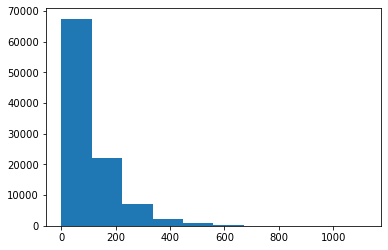

In [6]:
plt.hist(results)
print()

## Program 2

In [7]:
i = 2
with open("programs/{}.json".format(str(i)), 'rb') as f:
            exp = json.load(f)

In [8]:
L = 100000
results = [None]*L

for l in range(L):
    results[l] = evaluate_outer(exp).item()

In [9]:
results = np.array(results)
expectation = np.mean(results)
print("Expectation: {}".format(expectation))

Expectation: 0.984476921248436


In [10]:
var = np.std(results)**2
print("Variance: {}".format(var))

Variance: 4.987506960226637


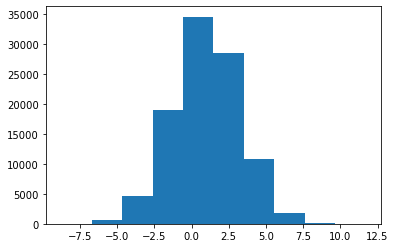

In [11]:
plt.hist(results)
print()

# Program 3

In [12]:
i = 3
with open("programs/{}.json".format(str(i)), 'rb') as f:
            exp = json.load(f)

In [13]:
L = 10000
results = [None]*L

for l in range(L):
    results[l] = evaluate_outer(exp)
    
results = torch.stack(results)

In [14]:
results = results.numpy()

In [15]:
expectations = np.mean(results, axis=0)
print("Expectations: {}".format(list(expectations)))

Expectations: [1.0052, 1.4108, 1.4167, 1.4174, 1.4133, 1.4141, 1.4086, 1.4222, 1.4092, 1.4122, 1.4136, 1.4228, 1.4209, 1.4115, 1.4273, 1.4056, 1.4121]


In [16]:
variances = np.std(results, axis=0)**2
print("Variances: {}".format(list(variances)))

Variances: [0.6747729599999972, 0.5478433599999987, 0.542661110000006, 0.5427772400000264, 0.5480831100000555, 0.543821189999931, 0.5438460399999762, 0.5463471599999523, 0.5481553600000899, 0.5438911599999773, 0.5389350399999777, 0.5370401600000176, 0.5399431900000441, 0.5509677500000137, 0.5429147099999434, 0.54628863999993, 0.5466735899999106]


Text(0.5, 1.0, 'Histogram for dim=0')

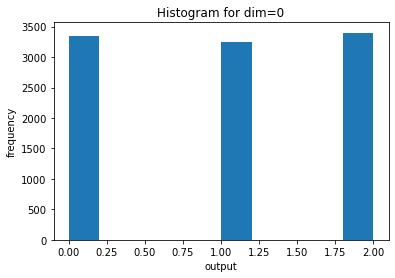

In [17]:
i = 0
plt.hist(results[:, i])
plt.xlabel("output")
plt.ylabel("frequency")
plt.title("Histogram for dim={}".format(i))

Text(0.5, 1.0, 'Histogram for dim=1')

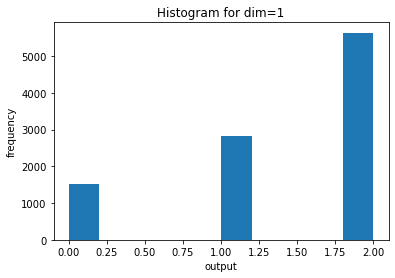

In [18]:
i = 1
plt.hist(results[:, i])
plt.xlabel("output")
plt.ylabel("frequency")
plt.title("Histogram for dim={}".format(i))

Text(0.5, 1.0, 'Histogram for dim=2')

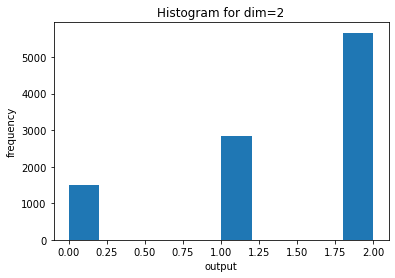

In [19]:
i = 2
plt.hist(results[:, i])
plt.xlabel("output")
plt.ylabel("frequency")
plt.title("Histogram for dim={}".format(i))

Text(0.5, 1.0, 'Histogram for dim=3')

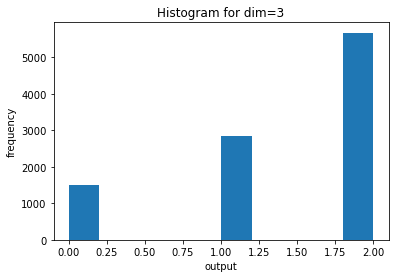

In [20]:
i = 3
plt.hist(results[:, i])
plt.xlabel("output")
plt.ylabel("frequency")
plt.title("Histogram for dim={}".format(i))

Text(0.5, 1.0, 'Histogram for dim=4')

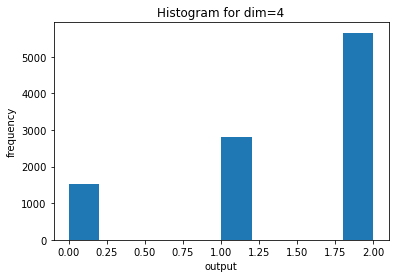

In [21]:
i = 4
plt.hist(results[:, i])
plt.xlabel("output")
plt.ylabel("frequency")
plt.title("Histogram for dim={}".format(i))

Text(0.5, 1.0, 'Histogram for dim=5')

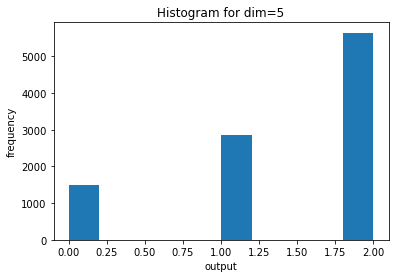

In [22]:
i = 5
plt.hist(results[:, i])
plt.xlabel("output")
plt.ylabel("frequency")
plt.title("Histogram for dim={}".format(i))

Text(0.5, 1.0, 'Histogram for dim=6')

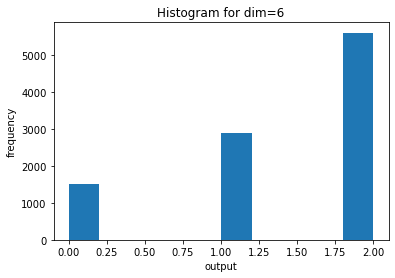

In [23]:
i = 6
plt.hist(results[:, i])
plt.xlabel("output")
plt.ylabel("frequency")
plt.title("Histogram for dim={}".format(i))

Text(0.5, 1.0, 'Histogram for dim=7')

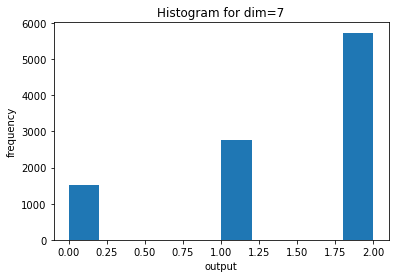

In [24]:
i = 7
plt.hist(results[:, i])
plt.xlabel("output")
plt.ylabel("frequency")
plt.title("Histogram for dim={}".format(i))

Text(0.5, 1.0, 'Histogram for dim=8')

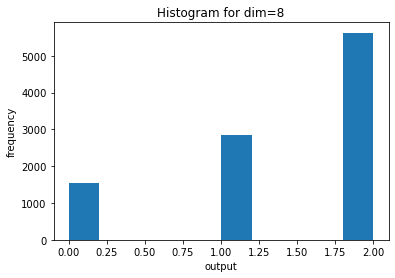

In [25]:
i = 8
plt.hist(results[:, i])
plt.xlabel("output")
plt.ylabel("frequency")
plt.title("Histogram for dim={}".format(i))

Text(0.5, 1.0, 'Histogram for dim=9')

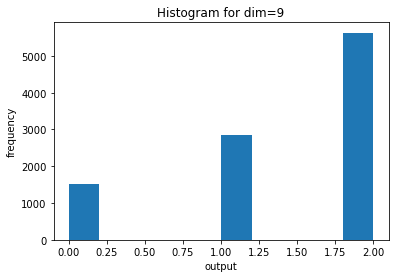

In [26]:
i = 9
plt.hist(results[:, i])
plt.xlabel("output")
plt.ylabel("frequency")
plt.title("Histogram for dim={}".format(i))

Text(0.5, 1.0, 'Histogram for dim=10')

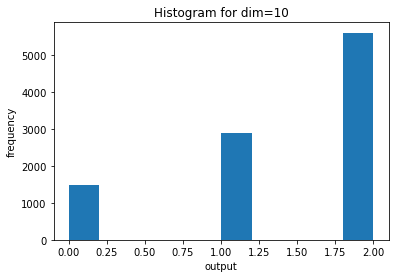

In [27]:
i = 10
plt.hist(results[:, i])
plt.xlabel("output")
plt.ylabel("frequency")
plt.title("Histogram for dim={}".format(i))

Text(0.5, 1.0, 'Histogram for dim=11')

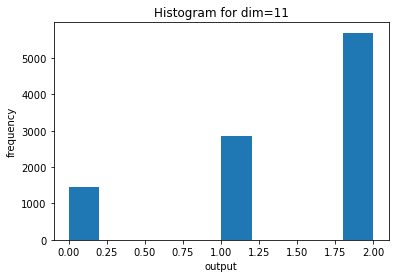

In [28]:
i = 11
plt.hist(results[:, i])
plt.xlabel("output")
plt.ylabel("frequency")
plt.title("Histogram for dim={}".format(i))

Text(0.5, 1.0, 'Histogram for dim=12')

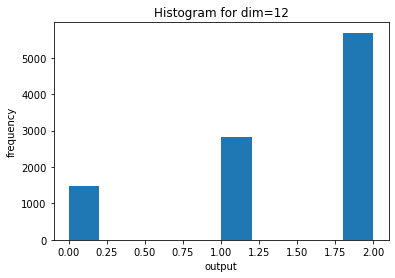

In [29]:
i = 12
plt.hist(results[:, i])
plt.xlabel("output")
plt.ylabel("frequency")
plt.title("Histogram for dim={}".format(i))

Text(0.5, 1.0, 'Histogram for dim=13')

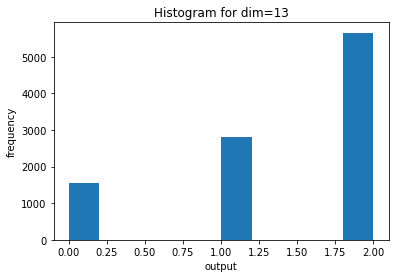

In [30]:
i = 13
plt.hist(results[:, i])
plt.xlabel("output")
plt.ylabel("frequency")
plt.title("Histogram for dim={}".format(i))

Text(0.5, 1.0, 'Histogram for dim=14')

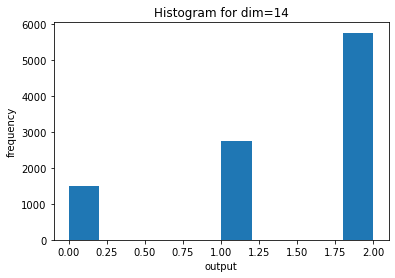

In [31]:
i = 14
plt.hist(results[:, i])
plt.xlabel("output")
plt.ylabel("frequency")
plt.title("Histogram for dim={}".format(i))

Text(0.5, 1.0, 'Histogram for dim=15')

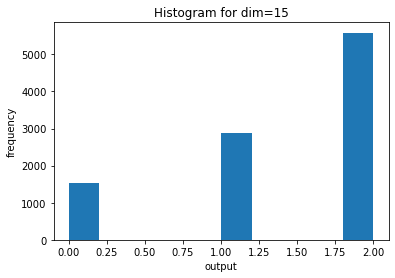

In [32]:
i = 15
plt.hist(results[:, i])
plt.xlabel("output")
plt.ylabel("frequency")
plt.title("Histogram for dim={}".format(i))

Text(0.5, 1.0, 'Histogram for dim=16')

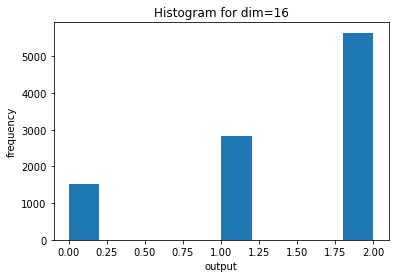

In [33]:
i = 16
plt.hist(results[:, i])
plt.xlabel("output")
plt.ylabel("frequency")
plt.title("Histogram for dim={}".format(i))